# Generate Gaussian Samples

## Positive Samples

We are going to demostrate the RBF network for 3 dimensional Guassian distribution.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.set_option("display.max_rows",15)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class hp:
    n = 1000
    f = 2

train_mean = np.full(shape=(hp.f), fill_value = 0)
train_var = [[1,0.6],[0.2,3]]
train_var = np.matmul(train_var, np.transpose(train_var)) # To make sure that the covariance matrix in positive semi-definate

test_mean_1 = np.full(shape=(hp.f), fill_value = 0.5)
test_var_1 = [[1,1.6],[0.6,2]]
test_var_1 = np.matmul(test_var_1, np.transpose(test_var_1))

test_mean_2 = np.full(shape=(hp.f), fill_value = 10)
test_var_2 = [[1,0.6],[2.2,3]]
test_var_2 = np.matmul(test_var_2, np.transpose(test_var_2))

test_mean_3 = np.full(shape=(hp.f), fill_value = 20)
test_var_3 = [[1,0.6],[0.2,3]]
test_var_3 = np.matmul(test_var_3, np.transpose(test_var_3))


class Dataset:
    train_positive = pd.DataFrame(
        np.random.multivariate_normal(mean=train_mean, cov=train_var, size = hp.n))
    
    test_negative_1 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_1, cov=test_var_1, size = hp.n))
    
    test_negative_2 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_2, cov=test_var_2, size = hp.n))
    
    test_negative_3 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_3, cov=test_var_3, size = hp.n))
    

## Negative Samples

In [3]:
Dataset.train_positive

,0,1
0,-0.826634,-0.980852
1,0.585001,-0.706837
2,-0.381235,2.592789
3,2.427929,5.711129
4,-0.839688,-1.162087
5,-0.165356,-2.271399
6,-0.959446,-0.831197
...,...,...
993,0.779339,-0.720653
994,3.047146,2.162095


Training Data (Normal)

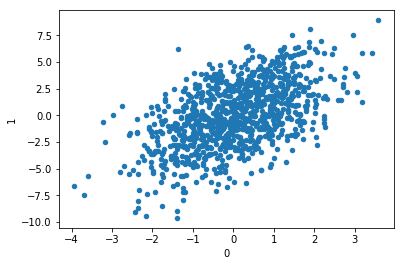

In [4]:
Dataset.train_positive.plot.scatter(x=0, y=1)

Testing Data 1 (Anamoly)

Similar Mean Different Variation

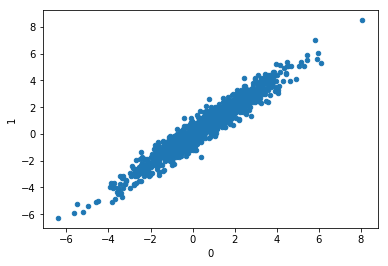

In [5]:
Dataset.test_negative_1.plot.scatter(x=0, y=1)

Testing Data 2 (Anamoly)

Different Mean Different Variation

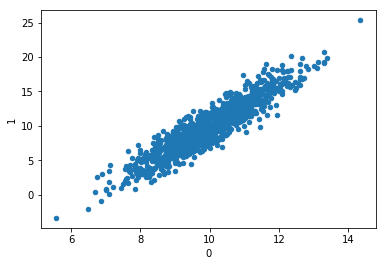

In [6]:
Dataset.test_negative_2.plot.scatter(x=0, y=1)

Testing Data 3 (Anamoly)

Different Mean similar Variation 

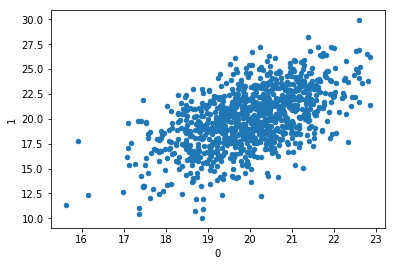

In [7]:
Dataset.test_negative_3.plot.scatter(x=0, y=1)

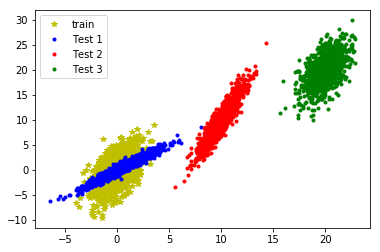

In [8]:
plt.plot(Dataset.train_positive[0], Dataset.train_positive[1], 'y*', label='train')

plt.plot(Dataset.test_negative_1[0], Dataset.test_negative_1[1], 'b.', label='Test 1')
plt.plot(Dataset.test_negative_2[0], Dataset.test_negative_2[1], 'r.', label='Test 2')
plt.plot(Dataset.test_negative_3[0], Dataset.test_negative_3[1], 'g.', label='Test 3')
plt.legend()

In [14]:


class network:
    
    params = {}
    
    def __init__(self):
        self.X = tf.placeholder(tf.float32, [hp.n, hp.f])
        
    def get_cost(self, U, Q, Q_, Z):
        
        #inverse_regularizer = tf.pow((tf.matmul(Q, Q_) - tf.eye(hp.f)), 2)
        cost = (U + tf.log(Z)) #+ tf.reduce_sum(inverse_regularizer)) # get -ve log likelihood
        
        self.params.update({'U_':tf.reduce_mean(U), 'logZ':tf.log(Z)}) #, 'ir': tf.reduce_sum(inverse_regularizer)
        return tf.reduce_mean(cost)
    
    def get_optimizer(self):
        
        n = hp.n
        f = hp.f
        
        X = self.X
        
        P = tf.Variable(tf.truncated_normal([f]))
        Q_ = tf.Variable(tf.truncated_normal([f,f]))
        #Q_ = tf.Variable(tf.truncated_normal([f,f]))

        Q = tf.matmul(Q_, tf.transpose(Q_)) 
        
        M = P - tf.matmul(X, Q)
        print('M', M.get_shape())
        
        R = tf.matmul(M, Q)
        print('R', R.get_shape())
        
        V = tf.matmul(R, tf.transpose(M))
        print('V', V.get_shape())
        
        U = tf.reduce_sum(V, axis = 1, keepdims = True)
        print('U', U.get_shape())
        
        Q_det = tf.matrix_determinant(Q)
        print('Q_det', Q_det.get_shape())
        
        Z = tf.pow(tf.multiply(tf.pow(6.28,f), Q_det), 1/2)
        print('Z', Z.get_shape())
        
        Y_ = tf.divide(tf.exp(-U/2), Z)
        print("Y_", Y_.get_shape())
        
        loss = self.get_cost(U, Q, Q_, Z) # 1- Y_[0]
        train = tf.train.AdamOptimizer(0.001).minimize(loss)
        
        self.params.update({'U': U, 'M':M, 'R':R, 'Z':Z, 'Q_det':Q_det})
        
        return train, loss, Y_, self.params


In [16]:
epochs = 1000
net = network()
loss_arr = []
output_tensors = net.get_optimizer()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        X = np.reshape(Dataset.train_positive.values[0:hp.n], (hp.n, -1))
        train, loss, Dataset.Y_, params = sess.run(output_tensors, feed_dict={net.X:X})
        print("epoch", epoch, "loss", loss, 'Z', params['Z'], 'U_', params['U_'], 'LogZ',params['logZ']) #, 'IR', params['ir']
        loss_arr.append(loss)
        if(np.abs(loss) < 0.1):
            break
        #print(params)

M (1000, 2)
R (1000, 2)
V (1000, 1000)
U (1000, 1)
Q_det ()
Z ()
Y_ (1000, 1)
epoch 0 loss 633.20105 Z 3.51889 U_ 631.94293 LogZ 1.2581456
epoch 1 loss 628.16486 Z 3.5104635 U_ 626.90924 LogZ 1.255748
epoch 2 loss 623.1599 Z 3.502039 U_ 621.90674 LogZ 1.2533454
epoch 3 loss 618.18616 Z 3.4936156 U_ 616.93524 LogZ 1.2509372
epoch 4 loss 613.24414 Z 3.485196 U_ 611.9956 LogZ 1.2485243
epoch 5 loss 608.3341 Z 3.4767797 U_ 607.0881 LogZ 1.2461065
epoch 6 loss 603.45636 Z 3.4683685 U_ 602.2129 LogZ 1.2436843
epoch 7 loss 598.61176 Z 3.4599621 U_ 597.3704 LogZ 1.2412577
epoch 8 loss 593.7999 Z 3.4515626 U_ 592.561 LogZ 1.2388271
epoch 9 loss 589.02136 Z 3.4431698 U_ 587.785 LogZ 1.2363925
epoch 10 loss 584.2766 Z 3.4347856 U_ 583.0426 LogZ 1.2339545
epoch 11 loss 579.5657 Z 3.4264092 U_ 578.3342 LogZ 1.2315128
epoch 12 loss 574.8891 Z 3.4180427 U_ 573.66 LogZ 1.229068
epoch 13 loss 570.24664 Z 3.4096859 U_ 569.02014 LogZ 1.2266202
epoch 14 loss 565.6389 Z 3.40134 U_ 564.41486 LogZ 1.2241695


In [17]:
pd.DataFrame(Dataset.Y_)

,0
0,7.399890
1,3.903652
2,0.097829
3,0.001307
4,9.195578
5,29.370113
6,6.386269
...,...
993,3.799349
994,0.075671


In [18]:
pd.DataFrame(params['U'])

,0
0,-1.324312
1,-0.045207
2,7.327690
3,15.959290
4,-1.758827
5,-4.081337
6,-1.029682
...,...
993,0.008959
994,7.841351
